In [1]:
import numpy as np

import random
import h5py
from nn_util import *
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as K
from keras.initializers import *
import tensorflow

import os
import random
import time
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] = "serif"
matplotlib.rcParams['font.serif'] = "Symbola"
matplotlib.rcParams['font.size'] = 12
import glob

import operator
import math
import re

# for reproducibility
np.random.seed(1337) 
random.seed(1337)

from keras.activations import softmax

# increase recursion limit for adaptive VQ
import sys
sys.setrecursionlimit(40000)

np.set_printoptions(formatter={'float_kind':'{:4f}'.format})

Using TensorFlow backend.


In [2]:
# control amount of GPU memory used
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
set_session(tf.Session(config=config))

In [3]:
import consts
consts.NBINS = 5
consts.BINS_INIT = np.linspace(-1.0, 1.0, consts.NBINS)
consts.QUANT_BINS = K.variable(consts.BINS_INIT, name = 'QUANT_BINS')
consts.QUANTIZATION_ON = K.variable(True, name = 'QUANTIZATION_ON')

In [4]:
# external custom code I wrote
from load_data import *
from windowing import *
from pesq import *
from consts import *
from nn_blocks import *
from perceptual_loss import *
from evaluation import *

In [5]:
NUM_CODEBOOKS = 32
CODEBOOKS_INIT = np.linspace(-1.0, 1.0, NBINS)
CODEBOOKS_INIT = np.expand_dims(CODEBOOKS_INIT, 0)
CODEBOOKS_INIT = np.repeat(CODEBOOKS_INIT, NUM_CODEBOOKS, 0)
CODEBOOKS = K.variable(CODEBOOKS_INIT)

In [6]:
# quantization: takes in 1. [BATCH x WINDOW_SIZE] -- window
#                        2. [BATCH x NUM_CODEBOOKS] -- codebooks choice (1-hot)
#               and returns [BATCH x WINDOW_SIZE x NBINS] -- quantized (1-hot)
#
class SwitchedCodebookQuantization(Layer):
    def build(self, input_shape):
        self.QUANT_TEMP = K.variable(500.0)
        self.trainable_weights = [CODEBOOKS, self.QUANT_TEMP]
        super(SwitchedCodebookQuantization, self).build(input_shape)
    
    def call(self, x, mask=None):
        # sig is an array: [BATCH x WINDOW_SIZE]
        # c_choice is an array: [BATCH x NUM_CODEBOOKS]
        sig = x[0]
        c_choice = x[1]
        
        # batch_codebooks becomes: [BATCH x NBINS]
        batch_codebooks = K.dot(c_choice, CODEBOOKS)
        
        # x is an array: [BATCH x WINDOW_SIZE]
        # x_r becomes:   [BATCH x WINDOW_SIZE x 1]
        x_r = K.reshape(sig, (-1, sig.shape[1], 1))

        # batch_codebooks is an array: [BATCH x NBINS]
        # q_r becomes:    [BATCH x 1 x NBINS]
        c_r = K.reshape(batch_codebooks, (-1, 1, NBINS))

        # get L1 distance from each element to each of the bins
        # dist is: [BATCH x WINDOW_SIZE x NBINS]
        dist = K.abs(x_r - c_r)

        # turn into softmax probabilities, which we return
        enc = softmax(self.QUANT_TEMP * -dist)
        
        #quant_on = enc
        #quant_off = K.zeros_like(enc)[:, :, 1:]
        #quant_off = K.concatenate([K.reshape(x, (-1, x.shape[1], 1)),
        #                           quant_off], axis = 2)
        
        #return [K.switch(QUANTIZATION_ON, quant_on, quant_off), c_choice]
        return enc
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0][0], input_shape[0][1], NBINS)

In [7]:
# dequantization: takes in 1. [BATCH x WINDOW_SIZE x NBINS]
#                          2. [BATCH x NUM_CODEBOOKS]
#                 and returns [BATCH x WINDOW_SIZE]
class SwitchedCodebookDequantization(Layer):
    def call(self, x, mask=None):
        enc = x[0]
        c_choice = x[1]
        
        batch_codebooks = K.dot(c_choice, CODEBOOKS)
        dec = K.batch_dot(enc, K.expand_dims(batch_codebooks))
        dec = K.reshape(dec, (-1, dec.shape[1]))

        #quant_on = dec
        #quant_off = K.reshape(enc[:, :, :1], (-1, enc.shape[1]))
        #return K.switch(QUANTIZATION_ON, quant_on, quant_off)
        return dec
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0][0], input_shape[0][1])

In [8]:
[train_paths, val_paths, test_paths], \
[train_waveforms, val_waveforms, test_waveforms], \
[train_procwave, val_procwave, test_procwave], \
[train_wparams, val_wparams, test_wparams], \
[train_windows, val_windows, test_windows] = load_data(TRAIN_SIZE, VAL_SIZE, TEST_SIZE)

In [9]:
# flatten all of the train windows into vectors
train_processed = np.array([i for z in train_windows for i in z])
train_processed = np.reshape(train_processed, (train_processed.shape[0], WINDOW_SIZE, 1))

# randomly shuffle data, if we want to
if (RANDOM_SHUFFLE):
    np.random.seed(1337)
    train_processed = np.random.permutation(train_processed)
    
print train_processed.shape
print np.mean(train_processed, axis=None)
print np.std(train_processed, axis=None)
print np.min(train_processed, axis = None)
print np.max(train_processed, axis = None)

X_train = np.copy(train_processed)

(101750, 512, 1)
3.81413e-06
0.103483
-1.0
1.0


# Switched Codebook Quantization

In [10]:
input_dim = (WINDOW_SIZE, 1)
model_input = Input(shape = input_dim)

enc_input = Input(shape = input_dim)
enc = Reshape((WINDOW_SIZE,))(enc_input)

# figure out which codebook to use
book_choice = enc
book_choice = Lambda(lambda x : keras_dft_mag(x, DFT_REAL, DFT_IMAG),
                    output_shape = lambda s : s)(book_choice)
book_choice = Dense(NUM_CODEBOOKS,
                    kernel_initializer = W_INIT)(book_choice)
book_choice = Lambda(lambda x : softmax(500.0 * x),
                     output_shape = lambda s : s)(book_choice)

enc = SwitchedCodebookQuantization()([enc, book_choice])
enc = Model(inputs = enc_input, outputs = [enc, book_choice])
enc.summary()

dec_input_1 = Input(shape = (WINDOW_SIZE, NBINS))
dec_input_2 = Input(shape = (NUM_CODEBOOKS,))
dec = SwitchedCodebookDequantization()([dec_input_1, dec_input_2])
dec = Reshape((WINDOW_SIZE, 1))(dec)
dec = Model(inputs = [dec_input_1, dec_input_2], outputs = dec)

model_reconstructed = dec(enc(model_input))
model = Model(inputs = [model_input], outputs = [model_reconstructed] * 2)

n_losses = 2
losses = [rmse, perceptual_distance]
weights = [30.0, 1.0]

model.compile(loss = losses,
              loss_weights = weights,
              optimizer = Adam())
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 512, 1)        0                                            
____________________________________________________________________________________________________
reshape_1 (Reshape)              (None, 512)           0           input_2[0][0]                    
____________________________________________________________________________________________________
lambda_1 (Lambda)                (None, 512)           0           reshape_1[0][0]                  
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 32)            16416       lambda_1[0][0]                   
___________________________________________________________________________________________

/usr/local/lib/python2.7/dist-packages/keras/engine/topology.py:1511: UserWarning: The list of outputs passed to the model is redundant. All outputs should only appear once. Found: [<tf.Tensor 'model_2/reshape_2/Reshape:0' shape=(?, 512, 1) dtype=float32>, <tf.Tensor 'model_2/reshape_2/Reshape:0' shape=(?, 512, 1) dtype=float32>]
  ' Found: ' + str(self.outputs))


In [11]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

In [12]:
def fancy_plot(x, y = None, yl = (-1.25, 1.25), dots = False, axes = True):
    if (axes):
        plt.axhline(0, color = 'gray')
        plt.axvline(0, color = 'gray')

    if (dots):
        sc = '.'
        ms = 3
    else:
        sc = '-'
        ms = 2
    
    if (y is not None):
        plt.plot(x, y, sc, ms = ms)
    else:
        plt.plot(x, sc, ms = ms)
    plt.grid()
    
    if (yl is not None):
        plt.ylim(yl[0], yl[1])
        
    if (y is None):
        plt.xlim(0, len(x))
        
    plt.show()

## Before training

In [13]:
test_model_on_wav("./SA1.wav", "SA1_quant_before", model)

MSE:         96474.1
Avg err:     189.912
PESQ:        1.02988314629


[96474.062, 189.91216, 1.0298831462860107]

Original


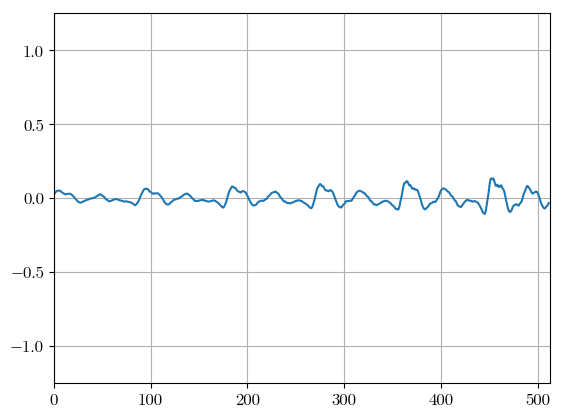

Reconstruction


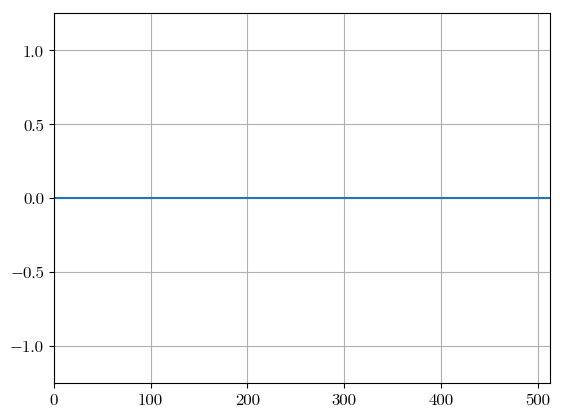

In [14]:
idx = 52

orig = X_train[idx].flatten()
recn = model.predict(X_train[idx:idx+1], verbose = 0)[0].flatten()

print "Original"
fancy_plot(orig, axes = False)

print "Reconstruction"
fancy_plot(recn, axes = False)

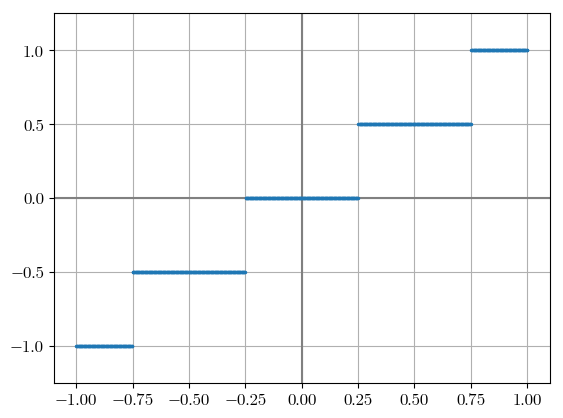

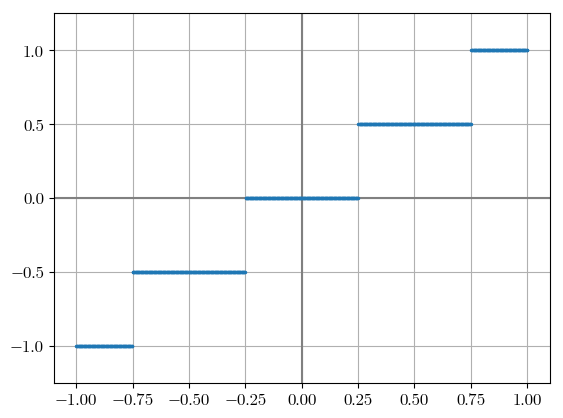

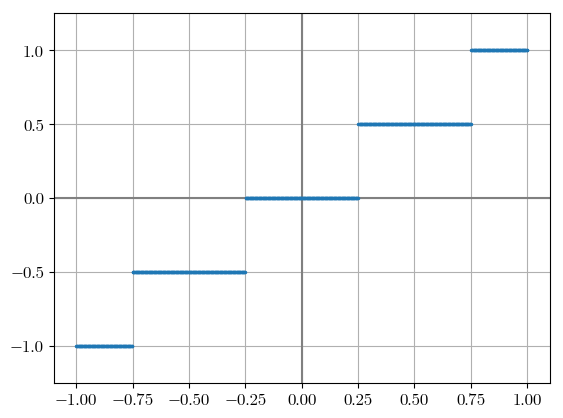

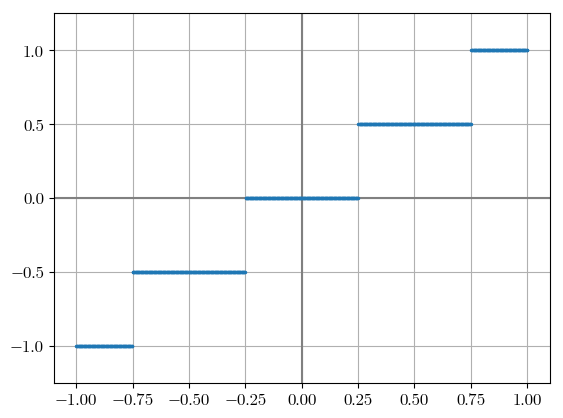

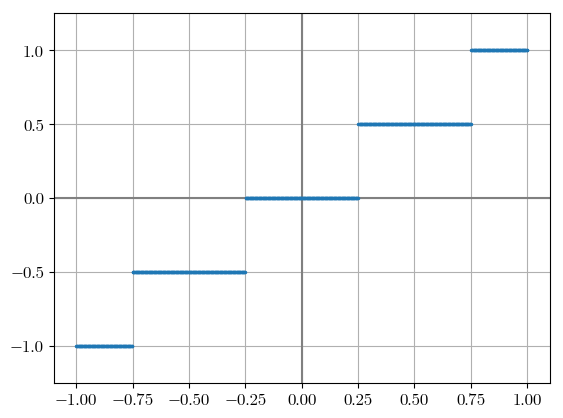

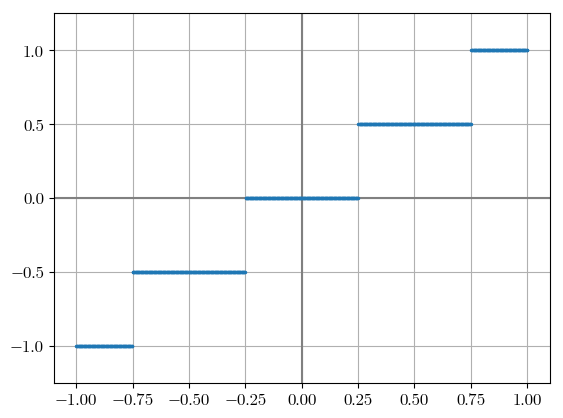

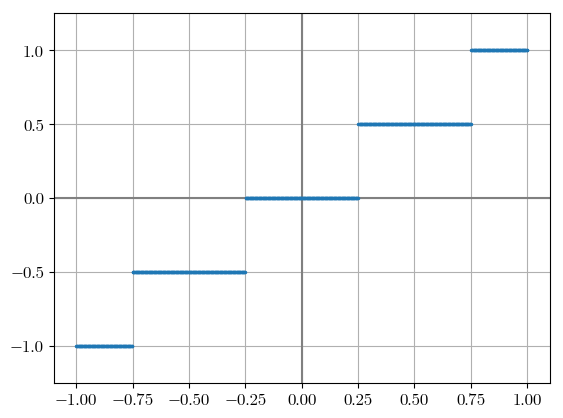

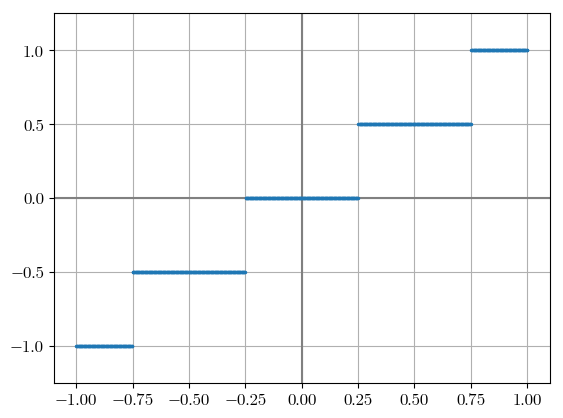

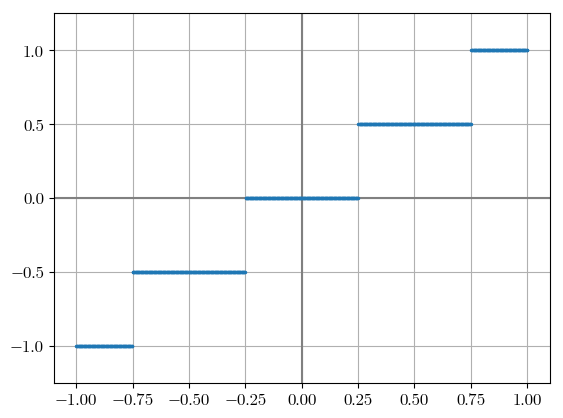

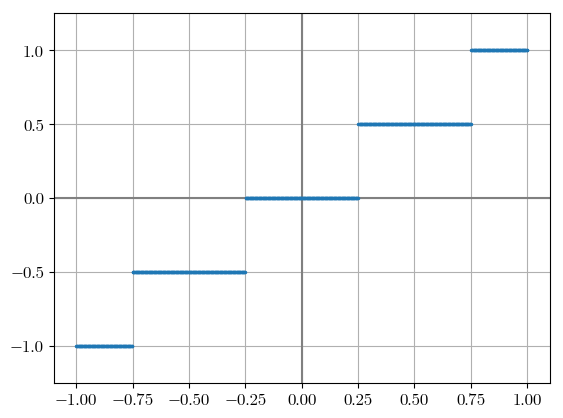

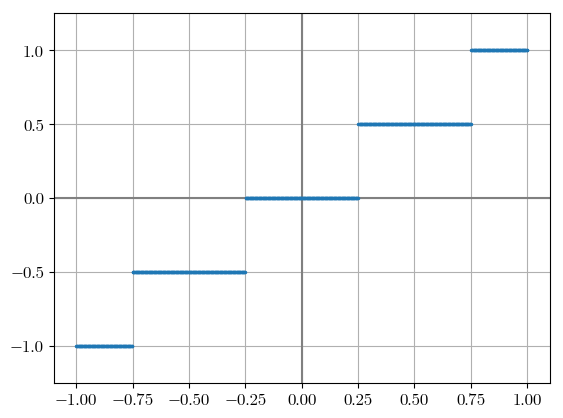

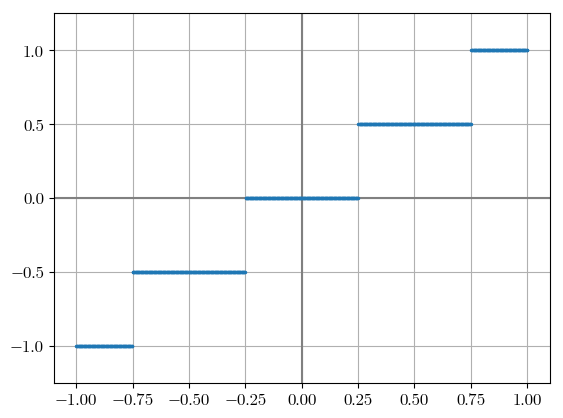

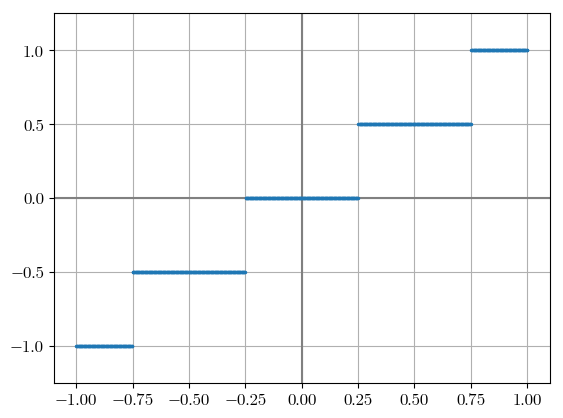

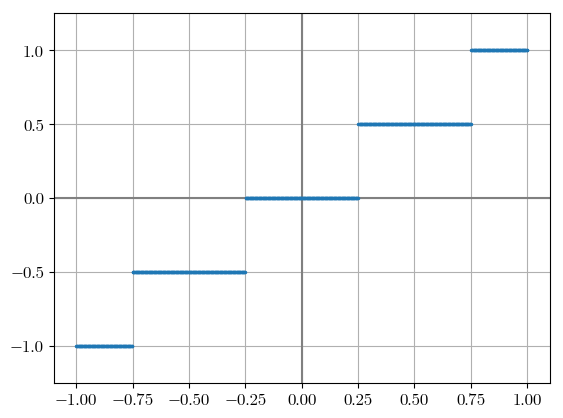

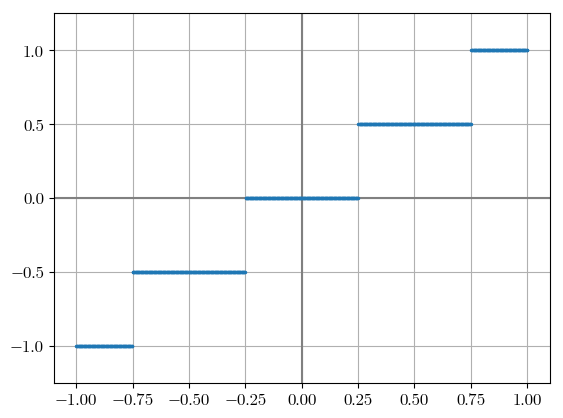

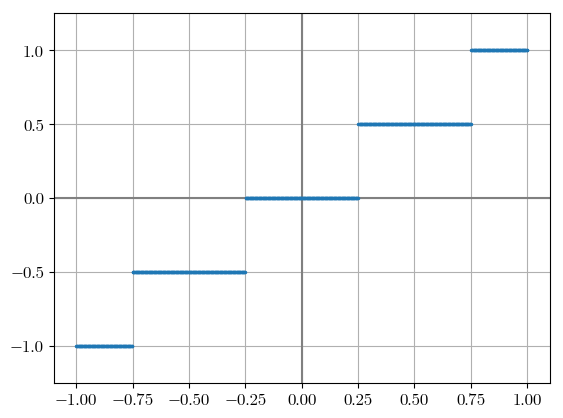

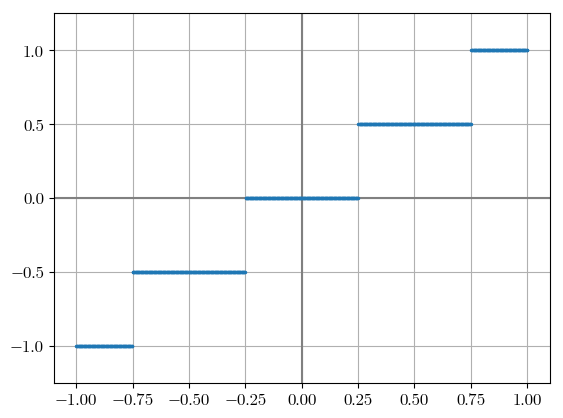

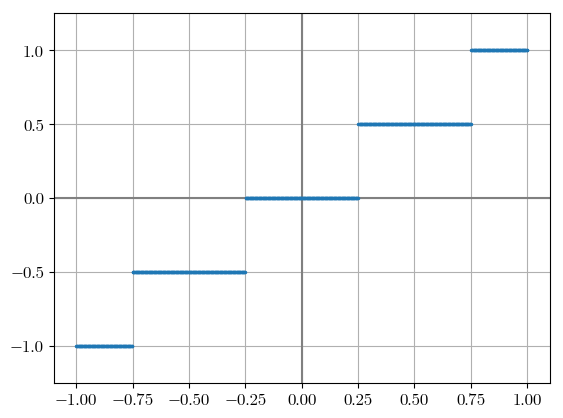

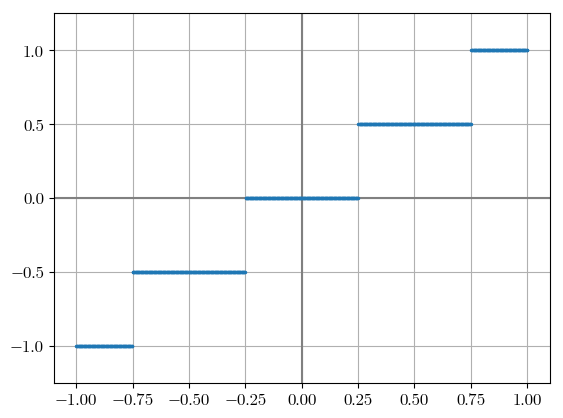

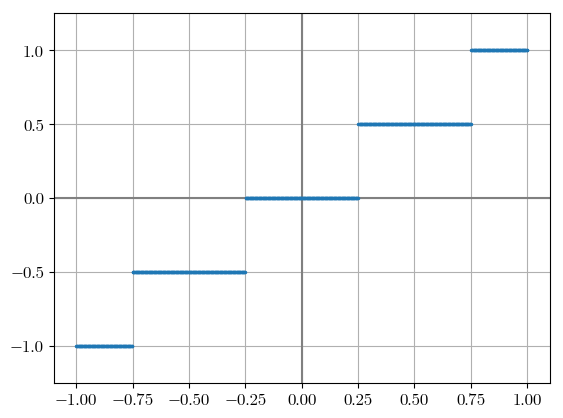

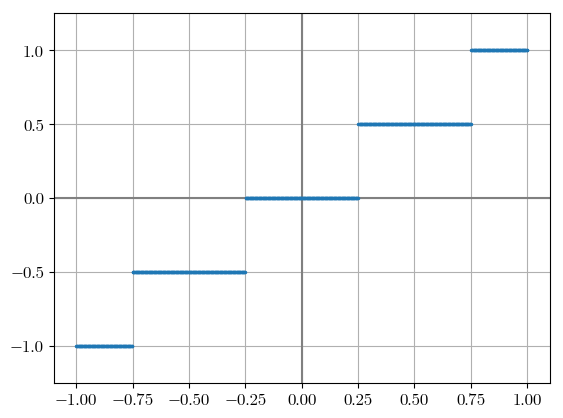

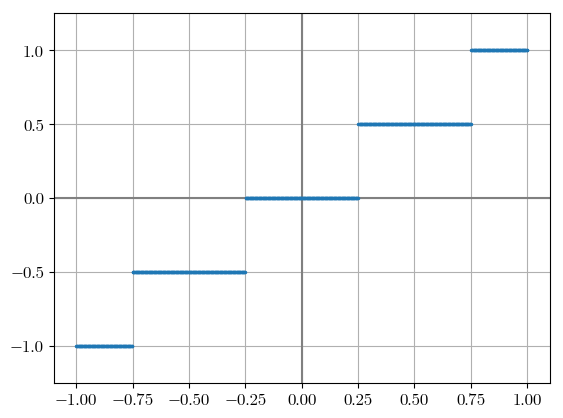

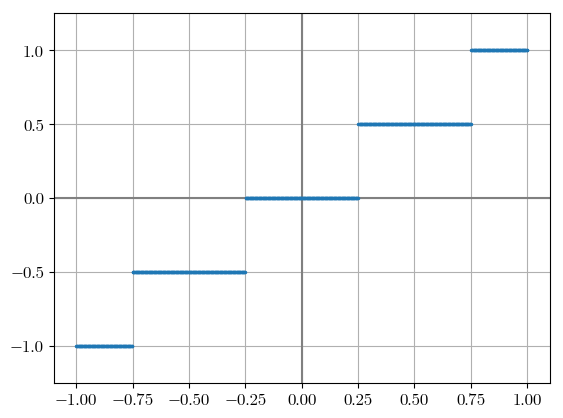

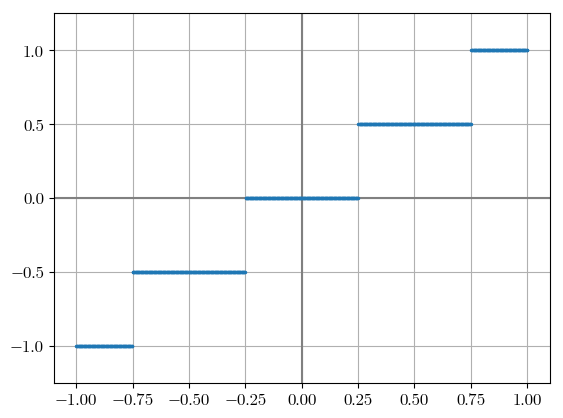

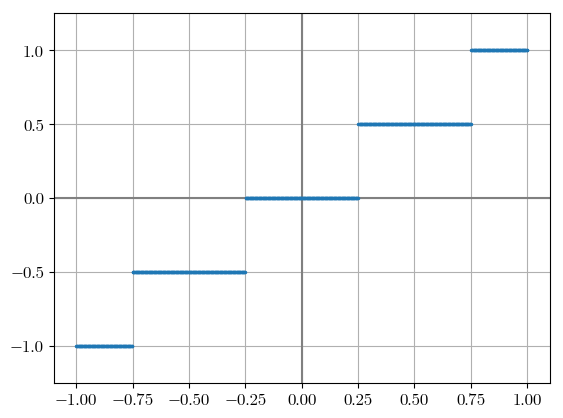

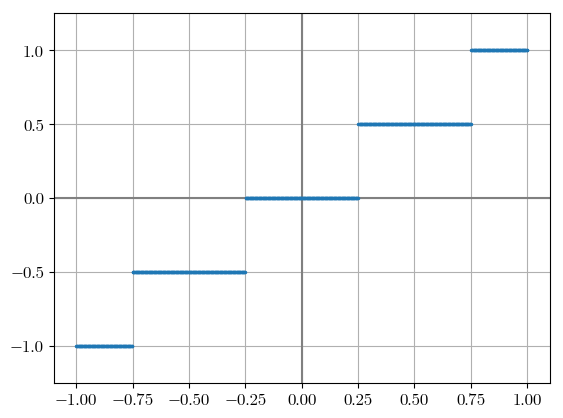

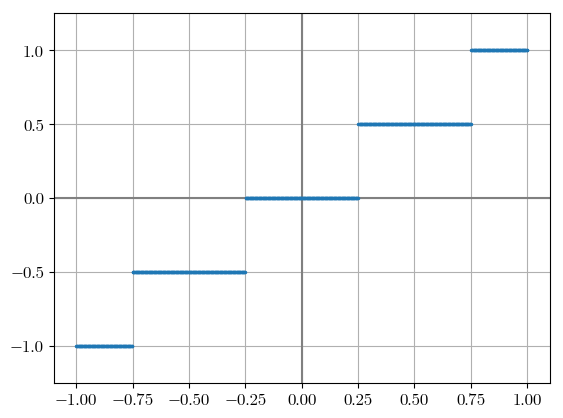

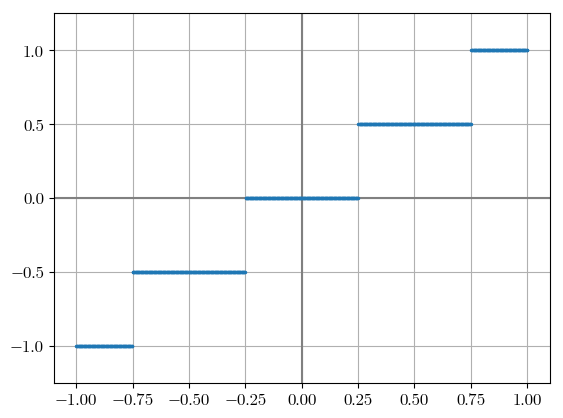

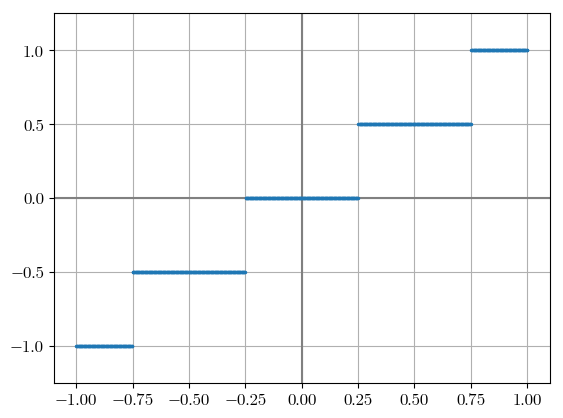

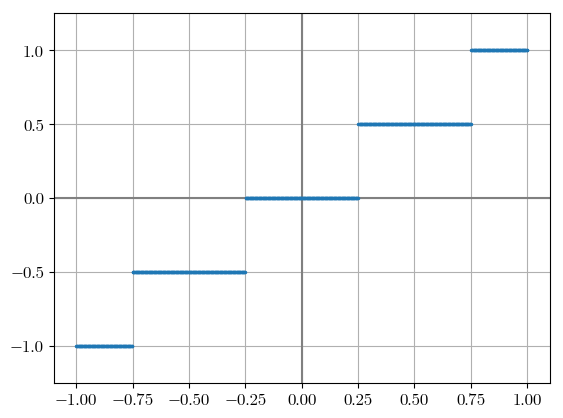

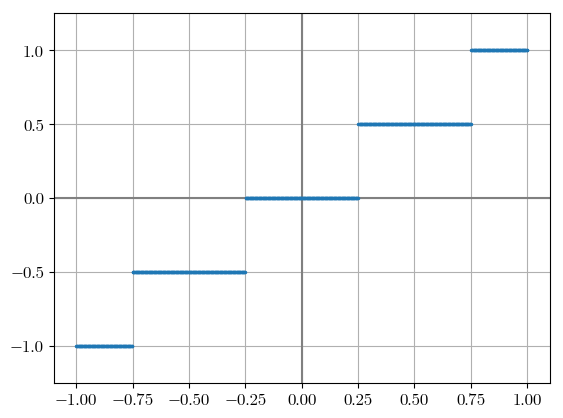

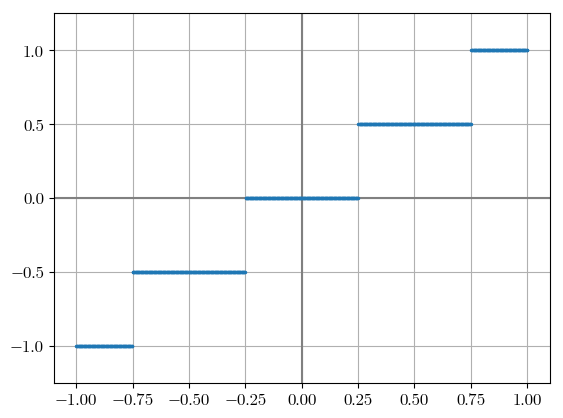

In [15]:
x = np.linspace(-1.0, 1.0, 800)

codes = K.eval(CODEBOOKS)
for bins in codes:
    y = [bins[np.argmin(np.abs(bins - num))] for num in x]
    fancy_plot(x, y, dots = True)

## After training

In [16]:
model.fit(X_train, [X_train] * n_losses, verbose = 1, epochs = 5, batch_size = 128)

Epoch 1/5
101750/101750 [==============================] - 9s - loss: 3.3109 - model_2_loss_1: 0.0312 - model_2_loss_2: 2.3761     
Epoch 2/5
101750/101750 [==============================] - 8s - loss: 2.6377 - model_2_loss_1: 0.0255 - model_2_loss_2: 1.8733     
Epoch 3/5
101750/101750 [==============================] - 8s - loss: 2.3817 - model_2_loss_1: 0.0240 - model_2_loss_2: 1.6624     
Epoch 4/5
101750/101750 [==============================] - 8s - loss: 2.3463 - model_2_loss_1: 0.0241 - model_2_loss_2: 1.6218     
Epoch 5/5
101750/101750 [==============================] - 8s - loss: 2.3454 - model_2_loss_1: 0.0241 - model_2_loss_2: 1.6213     


In [17]:
test_model_on_wav("./SA1.wav", "SA1_quant_after", model)

MSE:         49585.4
Avg err:     86.0908
PESQ:        1.29215157032


[49585.418, 86.090782, 1.2921515703201294]

Original


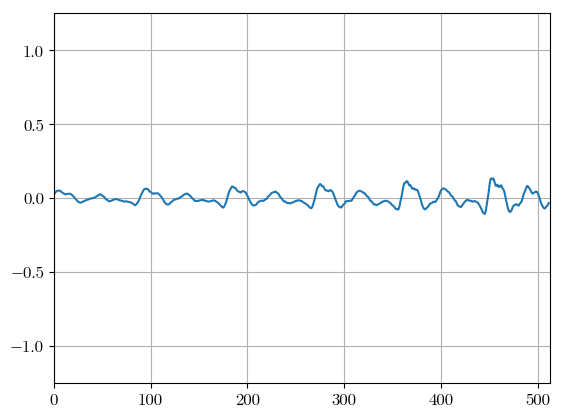

Reconstruction


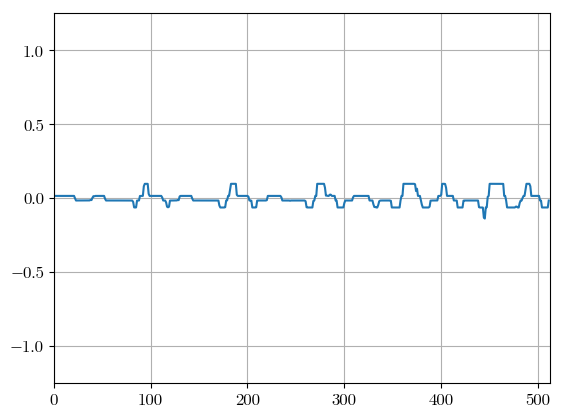

In [18]:
idx = 52

orig = X_train[idx].flatten()
recn = model.predict(X_train[idx:idx+1], verbose = 0)[0].flatten()

print "Original"
fancy_plot(orig, axes = False)

print "Reconstruction"
fancy_plot(recn, axes = False)